# Hypothesis Testing and Statistical Significance

In [2]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
plt.style.use('seaborn')

## Bootstrapping

Bootstrapping is a method of building up a theoretical population from a sample dataset. Given a sampled data set of size N, you resample **with replacement** to create a new sample data sets (also of size N). This means data points from your original sampled data set can be picked multiple times. Sample metrics can be computed on this new dataset. This process is repeated multiple times to get a distribution of the sample statistic.

In this example, we will be using the training values from the Richter scale prediction dataset which was collected via survey in Nepal after a major earthquake. Let us assume that the whole dataset is the actual population data, and a smaller random sample is our sample data.

In [3]:
SEED = 42
DATA_DIR = 'data/'

df = pd.read_parquet(f'{DATA_DIR}train_values.parquet')
df=df.set_index('building_id')
df_sample = df.sample(n=1000, random_state=SEED)
df.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


Here we can see that the mean and standard deviation of the sample data is slightly different compared to the population

In [4]:
age_mean = df['age'].mean()
age_sample_mean = df_sample['age'].mean()

age_std = df['age'].std(ddof=0)
age_sample_std = df_sample['age'].std()

print(f'Age\nPopulation Mean:{age_mean}\nSample Mean:{age_sample_mean}')
print(f'Age\nPopulation Std. Dev:{age_std}\nSample Std. Dev:{age_sample_std}')

Age
Population Mean:26.535028645323695
Sample Mean:25.515
Age
Population Std. Dev:73.5657953759027
Sample Std. Dev:71.39437605254305


### Generating the Bootstrap distribution

The function below creates a bootstrap distribution from a column of data. It resamples the column with replacement (same size) and then computes the mean. It is repeated multiple times and then returns the distribution of means.

In [5]:
# Generating a bootstrap distribution

def bootstrap(X, n=1000):
    boot_distn = []
    for i in tqdm(range(n)):
        boot_distn.append(
            X.sample(frac=1, replace=True).mean()
        )
    return boot_distn

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 7237.80it/s]


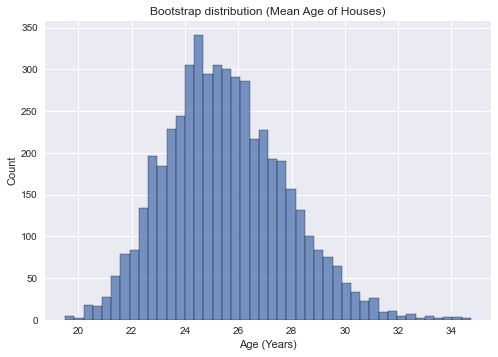

In [21]:
age_boot_distn = bootstrap(df_sample['age'], 5000)
sns.histplot(age_boot_distn)
plt.title('Bootstrap distribution (Mean Age of Houses)')
plt.xlabel('Age (Years)')
plt.show()

The bootstrap mean is closer to the sample mean than the true population mean. The standard error is the standard deviation of the bootstrap distribution. To approximate the standard deviation of the population:

$\sigma_{pop}$ $\approx$ std_error * $\sqrt{N_{sample}}$

In [12]:
age_boot_mean = np.mean(age_boot_distn)
print(f'Age\nTrue Population Mean:{age_mean}\nSample Mean:{age_sample_mean}\
        \nBootstrap Mean:{age_boot_mean}')

Age
True Population Mean:26.535028645323695
Sample Mean:25.515        
Bootstrap Mean:25.540882


In [8]:
std_error = np.std(age_boot_distn, ddof=1)
print(f'Age\nPopulation Std. Dev:{age_std}\nSample Std. Dev:{age_sample_std}\
        \nBootstrap Std. Dev:{std_error*np.sqrt(df_sample.shape[0])}')

Age
Population Std. Dev:73.5657953759027
Sample Std. Dev:71.39437605254305        
Bootstrap Std. Dev:71.76993609319547


## Getting the confidence intervals

A confidence interval is a range of estimates for an unknown quantity.

One way to estimate is to use the mean of the bootstrap distribution. The standard deviation will give you your margin of error.

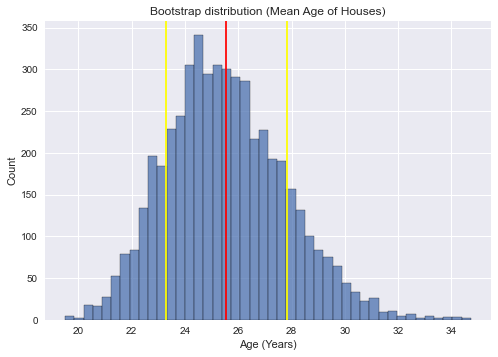

The expected age of houses is 25.540882 ± 2.269564655792243


In [22]:
sns.histplot(age_boot_distn)
plt.axvline(age_boot_mean, color='red')
plt.title('Bootstrap distribution (Mean Age of Houses)')
plt.xlabel('Age (Years)')
plt.axvline(age_boot_mean-std_error, color='yellow')
plt.axvline(age_boot_mean+std_error, color='yellow')
plt.show()
print(f'The expected age of houses is {age_boot_mean} ± {std_error}')

Another way is use quantiles get the range of values that satisfy a certain degree of confidence. In this example, we use a 95% confidence interval. This means that there is 95% certainty that the values will fall within that range.

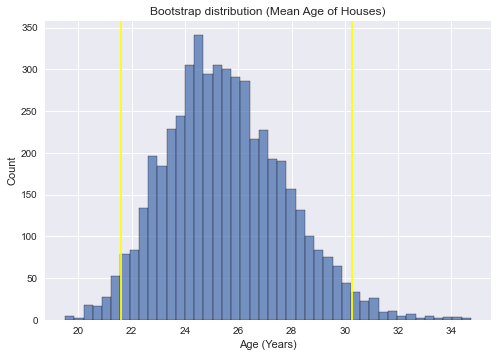

95% of the buildings are between 21.595 and 30.260374999999996 years old.


In [23]:
low, high = np.quantile(age_boot_distn, 0.025), np.quantile(age_boot_distn, 0.975)
sns.histplot(age_boot_distn)
plt.title('Bootstrap distribution (Mean Age of Houses)')
plt.xlabel('Age (Years)')
plt.axvline(low, color='yellow')
plt.axvline(high, color='yellow')
plt.show()
print(f'95% of the buildings are between {low} and {high} years old.')